# Experience Replay

In this project we study the influence of experience replay to improve Q-Learning.
We study the following experience replay techniques,
- Uniform ER
- Prioritized ER
- Hindsight ER
- Combined ER

Our experiements are limited to a subset of the Open-AI Gym's Classic Control environments,
- Cart Pole
- Mountain Car
- Acrobot

Using these ER methods for Q-Learning in the Gym environments, we measure the influence of i.i.d. and TD-error to quantiatively compare the performances.

Our hypothesis is that the effect of i.i.d. has a greater influence in the performance in comparision to the TD-error.

### Setup

In this section we load the required libraries to implement Q-Learning and run the environments of Open-AI Gym.

In [604]:
%matplotlib inline
import os
import sys

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F

import gym
gym.logger.set_level(40)

from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## Q-Learning

Here, we define a Neural Network for the Q function. The forward pass accepts the observation state and outputs the action values.

In [605]:
class QNetwork(nn.Module):
    def __init__(self, input_dim=4, num_hidden=128, output_dim=2):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(input_dim, num_hidden)
        self.l2 = nn.Linear(num_hidden, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))

In [606]:
# Let's instantiate and test if it works
input_dim = 4
num_hidden = 128
output_dim = 2
torch.manual_seed(1234)
model = QNetwork(input_dim, num_hidden, output_dim)

torch.manual_seed(1234)
test_model = nn.Sequential(
    nn.Linear(input_dim, num_hidden), 
    nn.ReLU(), 
    nn.Linear(num_hidden, output_dim)
)

x = torch.rand(10, 4)

# at this point we do not need backpropagation
with torch.no_grad():
    assert np.allclose(model(x).numpy(), test_model(x).numpy())

Some useful functions for training,

In [684]:
def get_epsilon(it):
    if it == 0:
        return 1
    return np.maximum(1 - it/1000, 0.05)

def select_action(model, state, epsilon):
    with torch.no_grad():
        actionProbs = model(torch.Tensor(state)).numpy()
    action = np.random.choice(len(actionProbs), 1) if np.random.rand() < epsilon else np.argmax(actionProbs)
    return int(action.squeeze())

def copy_model(source_model, target_model):
    target_model.load_state_dict(source_model.state_dict())

def append_sample(transition, model, target_model, discount_factor, memory):
    state, action, reward, next_state, done = transition
    target = model(torch.FloatTensor(state)).data
    old_val = target[0][action]
    target_val = target_model(torch.FloatTensor(next_state)).data
    if done:
        target[0][action] = reward
    else:
        target[0][action] = reward + discount_factor * torch.max(target_val)
    
    #TODO: See why error is always equal to 0. Errors calculated in train seem to make more sense...
    #Aren't we then calculating the errors twice? 
    #print(old_val, '-', target[0][action])
    error = abs(old_val - target[0][action])    
    transition = (state, action, reward, next_state, done)
    memory.push(transition, error)
    
    
def correlation_count(state, threshold = 0.8):
    
    cov=np.cov(state)
    corrcoeff = cov.copy()
    n_samples = cov.shape[0]
    for i in range(n_samples):
        corrcoeff[i,:]=corrcoeff[i,:]/np.sqrt(cov[i,i])
    for j in range(n_samples):
        corrcoeff[:,j]=corrcoeff[:,j]/np.sqrt(cov[j,j])
    
    return (np.sum(np.abs(corrcoeff)>threshold) - n_samples) / 2

In [682]:
def train(memory, model, target_model, batch_size, action_size, optimizer, discount_factor):

    if len(memory) < batch_size:
        return None, None, None #To match length of output

    transition_and_error, idxs, is_weights = memory.sample(batch_size)
    
    #Separate mini-batch into transition and TD error
    mini_batch, sampled_TD_error = zip(*transition_and_error)    
    sampled_TD_error = np.asarray(sampled_TD_error)
    
    #Set up data for training
    mini_batch = np.array(mini_batch).transpose()
    states = np.vstack(mini_batch[0])
    actions = list(mini_batch[1])
    rewards = list(mini_batch[2])
    next_states = np.vstack(mini_batch[3])
    dones = mini_batch[4]

    #Collect stats
    error_stats = (sampled_TD_error.mean(), np.median(sampled_TD_error), sampled_TD_error.max(), sampled_TD_error.std())
    iid_stats = correlation_count(states)
    
    # bool to binary
    dones = dones.astype(int)

    # Q function of current state
    states = torch.Tensor(states)
    pred = model(states)

    # one-hot encoding
    a = torch.LongTensor(actions).view(-1, 1)

    one_hot_action = torch.zeros(batch_size, action_size)
    one_hot_action.scatter_(1, a, 1)

    pred = torch.sum(pred.mul(torch.tensor(one_hot_action)), dim = 1)

    # Q function of next state
    next_states = torch.Tensor(next_states)
    next_pred = target_model(next_states).data

    rewards = torch.FloatTensor(rewards)
    dones = torch.FloatTensor(dones)

    # Q Learning: get maximum Q value at s' from target model
    target = rewards + (1 - dones) * discount_factor * next_pred.max(1)[0]
    target = torch.autograd.Variable(target)

    errors = torch.abs(pred - target).data.numpy()
    
    # update priority
    if isinstance(memory, PrioritizedMemory):
        for i in range(batch_size):
            idx = idxs[i]
            memory.update(idx, errors[i])

    optimizer.zero_grad()

    # MSE Loss function
    loss = F.mse_loss(pred, target)
    loss.backward()

    # and train
    optimizer.step()
    
    return loss.item(), error_stats, iid_stats

In [678]:
def run_episodes(model, target_model, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    #initialize output
    results_output = {}
    results_output['durations'] = np.zeros(num_episodes)
    results_output['mean_TD_error'] = np.zeros(num_episodes)
    results_output['median_TD_error'] = np.zeros(num_episodes)
    results_output['max_TD_error'] = np.zeros(num_episodes)
    results_output['std_TD_error'] = np.zeros(num_episodes)
    results_output['correlation_count'] = np.zeros(num_episodes)
    
    iteration = 0
    
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    scores = []

    for episode in tqdm(range(num_episodes)):
        done = False
        score = 0
        
        mean_TD_error = []
        median_TD_error = []
        max_TD_error = []
        std_TD_error = []
        correlation_count = []
        
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            action = select_action(model, state, get_epsilon(iteration))

            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            
            # if an action make the episode end, then gives penalty of -10
            reward = reward if not done or score == 499 else -10

            transition = (state, action, reward, next_state, done)
    
            append_sample(transition, model, target_model, discount_factor, memory)
    
            # Train
            loss, error_stats, iid_stats = train(memory, model, target_model, batch_size, action_size, optimizer, discount_factor)
            
            # Update
            score += reward
            state = next_state
            iteration += 1
            
            # Append stats
            if error_stats != None:
                results_output['durations'][episode] += 1
                mean_TD_error.append(error_stats[0])
                median_TD_error.append(error_stats[1])
                max_TD_error.append(error_stats[2])
                std_TD_error.append(error_stats[3])
                correlation_count.append(iid_stats)

            if done:
                # every episode update the target model to be same with model
                copy_model(model, target_model)

                # every episode, plot the play time
                score = score if score == 500 else score + 10
                scores.append(score)
         
        #Average stats per episode
        if len(mean_TD_error) > 0:
            results_output['mean_TD_error'][episode] = np.array(mean_TD_error).mean()
            results_output['median_TD_error'][episode] = np.array(median_TD_error).mean()
            results_output['max_TD_error'][episode] = np.array(max_TD_error).mean()
            results_output['std_TD_error'][episode] = np.array(std_TD_error).mean()
            results_output['correlation_count'][episode] = np.array(correlation_count).mean()
                
    return results_output

## Environment

We load the necessary Gym environments required for our experiments.

In [667]:
environments = ["CartPole-v0", "Acrobot-v1", "MountainCar-v0"]
envs = {}

print('Environment \t\t State Space \t Action Space')
print('----------- \t\t ----------- \t ------------')
for environment in environments:
    env = gym.envs.make(environment)
    envs[environment] = env
    print('{} \t\t {} \t {}'.format(
        environment,
        env.observation_space,
        env.action_space)
    )

Environment 		 State Space 	 Action Space
----------- 		 ----------- 	 ------------
CartPole-v0 		 Box(4,) 	 Discrete(2)
Acrobot-v1 		 Box(6,) 	 Discrete(3)
MountainCar-v0 		 Box(2,) 	 Discrete(3)


## Experience Replay

### ReplayMemory

In [657]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition, error):
        self.memory.append((transition, error))

    def sample(self, batch_size):
        raise NotImplementedError('Function sample is not defined')

    def __len__(self):
        return len(self.memory)

### No Experience Replay and Uniform Experience Replay

In [658]:
class NoneMemory(ReplayMemory):
    def sample(self, batch_size):
        #Samples a tuple of tuple of transitions and error - ((s, a, r, s', done), TDerror)
        return self.memory[-batch_size:], None, None # extra Nones to have the same behaviour as PER


class UniformMemory(ReplayMemory):
    def sample(self, batch_size):
        #Samples a tuple of tuple of transitions and error - ((s, a, r, s', done), TDerror)
        index = np.random.choice(len(self), batch_size, replace=False)
        return [self.memory[i] for i in index], None, None # extra Nones to have the same behaviour as PER

### Prioritized Experience Replay

In [659]:
# Source: https://github.com/rlcode/per

# SumTree
# a binary tree data structure where the parent’s value is the sum of its children
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype = object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])


class PrioritizedMemory:  # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.6
    beta = 0.4
    beta_increment_per_sampling = 0.001

    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.capacity = capacity

    def _get_priority(self, error):
        return (error + self.e) ** self.a
    
    def __len__(self):
        return self.tree.n_entries

    def push(self, sample, error):
        p = self._get_priority(error)
        self.tree.add(p, (sample, error))

    def sample(self, n):
        batch = []
        idxs = []
        segment = self.tree.total() / n
        priorities = []

        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            priorities.append(p)
            batch.append(data)
            idxs.append(idx)

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()
        
        return batch, idxs, is_weight

    def update(self, idx, error):
        p = self._get_priority(error)
        self.tree.update(idx, p)

Test if the memory module works as expected,

In [660]:
capacity = 10
memory = NoneMemory(capacity)

# Sample a transition
s = env.reset()
a = env.action_space.sample()
s_next, r, done, _ = env.step(a)

# Push a transition
memory.push((s, a, r, s_next, done), 0)

# Sample a batch size of 1
print(memory.sample(1)[0][0])

((array([-0.51567206,  0.        ]), 0, -1.0, array([-0.5167315 , -0.00105944]), False), 0)


Test if the train module works as expected,

In [661]:
# settings
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
input_dim = 2
output_dim = 2

model = QNetwork(input_dim, num_hidden, output_dim)
optimizer = optim.Adam(model.parameters(), learn_rate)

# setup memory
transition = memory.sample(1)[0][0][0]
memory = UniformMemory(10 * batch_size)

# fill with dummy data
for i in range(batch_size):
    memory.push(transition, 0)

# must prints loss, meanTDerror, (medianTDerror, maxTDerror, stdTDerror), Correlation count
print(train(memory, model, model, batch_size, output_dim, optimizer, discount_factor))

(0.9101533889770508, (0.0, 0.0, 0, 0.0), 2016.0)


# Run Experiments

In [679]:
def run(er_type='uniform', environment="CartPole-v0"):
    # load environment
    env = envs[environment]
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    num_hidden = 128

    # init networks
    model = QNetwork(state_size, num_hidden, action_size)
    target_model = QNetwork(state_size, num_hidden, action_size)

    copy_model(model, target_model)

    # run settings
    batch_size = 64
    discount_factor = 0.8
    learn_rate = 1e-3
    memory_size = 10000
    num_episodes = 100
    
    er_types = {
        'none': NoneMemory,
        'uniform': UniformMemory,
        'prioritized': PrioritizedMemory
    }

    memory = er_types[er_type](memory_size)
    seed = 42  # This is not randomly chosen

    # We will seed the algorithm (before initializing QNetwork!) for reproducability
    random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    #Return a dictionary of the relevant statistics per episode
    metrics = run_episodes(model, target_model, memory, env, num_episodes, batch_size, discount_factor, learn_rate)
    
    return metrics

## Results

In [685]:
exp_replays = ['none', 'uniform', 'prioritized']
#environments = ["CartPole-v0", "Acrobot-v1", "MountainCar-v0"] # one from ["CartPole-v0", "Acrobot-v1", "MountainCar-v0"]
environments = ["CartPole-v0"]

# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


def grid_search():
    results = {}
    #runs_values = runs.keys()
    for environment in environments:
        results[environment]=[]
        for er_type in exp_replays:
            print("Running {} in {}".format(er_type, environment))
            results[environment].append(smooth(run(er_type, environment), 10))
    return results


def test_run(environment="CartPole-v0"):
    for er_type in exp_replays:
        plt.plot(smooth(run(er_type, environment), 10))
    plt.title('Episode durations per episode')
    plt.legend(exp_replays)
    
# use results and then next cell for plotting - no need to get results multiple times
#results = grid_search()
# test_run()
run('uniform', "CartPole-v0")






  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.8494) - tensor(0.8494)
tensor(0.8540) - tensor(0.8540)
tensor(0.9192) - tensor(0.9192)
tensor(0.9712) - tensor(0.9712)
tensor(1.0148) - tensor(1.0148)
tensor(1.0533) - tensor(1.0533)
tensor(1.0868) - tensor(1.0868)
tensor(-10.) - tensor(-9.8784)
tensor(0.8619) - tensor(0.8619)
tensor(0.8514) - tensor(0.8514)
tensor(0.9150) - tensor(0.9150)
tensor(0.9629) - tensor(0.9629)
tensor(1.0046) - tensor(1.0046)
tensor(1.0434) - tensor(1.0434)
tensor(1.0758) - tensor(1.0758)
tensor(1.1079) - tensor(1.1079)
tensor(1.1425) - tensor(1.1425)
tensor(-10.) - tensor(-9.8205)
tensor(0.8424) - tensor(0.8424)
tensor(0.8543) - tensor(0.8543)
tensor(0.9208) - tensor(0.9208)
tensor(0.9695) - tensor(0.9695)
tensor(1.0122) - tensor(1.0122)
tensor(1.0505) - tensor(1.0505)
tensor(1.0839) - tensor(1.0839)
tensor(1.1185) - tensor(1.1185)
tensor(-10.) - tensor(-9.8448)
tensor(0.8572) - tensor(0.8572)
tensor(0.8459) - tensor(0.8459)
tensor(0.9124) - tensor(0.9124)
tensor(0.9598) - tensor(0.9598)
tensor(1.00





 22%|██▏       | 22/100 [00:01<00:03, 20.99it/s]

tensor(1.6985) - tensor(1.6985)
tensor(1.5340) - tensor(1.5340)
tensor(1.4197) - tensor(1.4197)
tensor(-10.) - tensor(-9.5893)
tensor(3.0700) - tensor(3.0700)
tensor(2.7193) - tensor(2.7193)
tensor(3.0354) - tensor(3.0354)
tensor(2.6846) - tensor(2.6846)
tensor(2.3697) - tensor(2.3697)
tensor(2.0884) - tensor(2.0884)
tensor(1.8411) - tensor(1.8411)
tensor(1.5826) - tensor(1.5826)
tensor(1.7280) - tensor(1.7280)
tensor(1.8665) - tensor(1.8665)
tensor(-10.) - tensor(-8.9811)
tensor(4.0784) - tensor(4.0784)
tensor(3.5391) - tensor(3.5391)
tensor(4.0604) - tensor(4.0604)
tensor(3.5239) - tensor(3.5239)
tensor(4.0473) - tensor(4.0473)
tensor(4.5837) - tensor(4.5837)
tensor(4.0558) - tensor(4.0558)
tensor(3.5296) - tensor(3.5296)
tensor(3.0568) - tensor(3.0568)
tensor(2.6866) - tensor(2.6866)
tensor(2.3329) - tensor(2.3329)
tensor(1.9864) - tensor(1.9864)
tensor(1.6485) - tensor(1.6485)
tensor(1.8859) - tensor(1.8859)
tensor(1.5323) - tensor(1.5323)
tensor(1.1844) - tensor(1.1844)
tensor(1.3





 35%|███▌      | 35/100 [00:02<00:03, 17.17it/s]

tensor(6.4281) - tensor(6.4281)
tensor(5.5453) - tensor(5.5453)
tensor(6.3974) - tensor(6.3974)
tensor(5.4976) - tensor(5.4976)
tensor(6.3381) - tensor(6.3381)
tensor(5.4184) - tensor(5.4184)
tensor(6.2506) - tensor(6.2506)
tensor(5.3087) - tensor(5.3087)
tensor(6.1321) - tensor(6.1321)
tensor(7.0643) - tensor(7.0643)
tensor(7.9409) - tensor(7.9409)
tensor(8.7947) - tensor(8.7947)
tensor(9.6589) - tensor(9.6589)
tensor(10.5814) - tensor(10.5814)
tensor(9.9320) - tensor(9.9320)
tensor(10.8983) - tensor(10.8983)
tensor(11.9315) - tensor(11.9315)
tensor(11.3847) - tensor(11.3847)
tensor(10.8436) - tensor(10.8436)
tensor(11.9186) - tensor(11.9186)
tensor(11.4352) - tensor(11.4352)
tensor(-10.) - tensor(-0.0442)
tensor(5.7887) - tensor(5.7887)
tensor(4.8659) - tensor(4.8659)
tensor(3.7147) - tensor(3.7147)
tensor(4.5670) - tensor(4.5670)
tensor(3.3674) - tensor(3.3674)
tensor(2.1080) - tensor(2.1080)
tensor(2.8494) - tensor(2.8494)
tensor(3.6163) - tensor(3.6163)
tensor(2.3159) - tensor(2.3





 45%|████▌     | 45/100 [00:03<00:03, 14.08it/s]

tensor(5.9240) - tensor(5.9240)
tensor(5.8054) - tensor(5.8054)
tensor(6.0396) - tensor(6.0396)
tensor(5.9154) - tensor(5.9154)
tensor(6.1606) - tensor(6.1606)
tensor(6.0394) - tensor(6.0394)
tensor(6.2857) - tensor(6.2857)
tensor(6.1766) - tensor(6.1766)
tensor(6.4241) - tensor(6.4241)
tensor(6.3357) - tensor(6.3357)
tensor(6.5681) - tensor(6.5681)
tensor(6.5190) - tensor(6.5190)
tensor(6.7158) - tensor(6.7158)
tensor(7.0293) - tensor(7.0293)
tensor(6.8059) - tensor(6.8059)
tensor(6.9131) - tensor(6.9131)
tensor(7.0481) - tensor(7.0481)
tensor(7.4418) - tensor(7.4418)
tensor(-10.) - tensor(-3.3245)
tensor(5.2487) - tensor(5.2487)
tensor(5.1008) - tensor(5.1008)
tensor(5.3268) - tensor(5.3268)
tensor(5.5171) - tensor(5.5171)
tensor(5.3383) - tensor(5.3383)
tensor(5.5013) - tensor(5.5013)
tensor(5.3377) - tensor(5.3377)
tensor(5.5463) - tensor(5.5463)
tensor(5.3712) - tensor(5.3712)
tensor(5.2358) - tensor(5.2358)
tensor(5.4604) - tensor(5.4604)
tensor(5.3331) - tensor(5.3331)
tensor(5.

tensor(5.5918) - tensor(5.5918)
tensor(5.2139) - tensor(5.2139)
tensor(5.6367) - tensor(5.6367)
tensor(6.2545) - tensor(6.2545)
tensor(5.6604) - tensor(5.6604)
tensor(6.2523) - tensor(6.2523)
tensor(5.6929) - tensor(5.6929)
tensor(-10.) - tensor(-4.7920)
tensor(4.5046) - tensor(4.5046)
tensor(4.7910) - tensor(4.7910)
tensor(4.5113) - tensor(4.5113)
tensor(4.8124) - tensor(4.8124)
tensor(4.5175) - tensor(4.5175)
tensor(4.8320) - tensor(4.8320)
tensor(4.5233) - tensor(4.5233)
tensor(4.8467) - tensor(4.8467)
tensor(4.5289) - tensor(4.5289)
tensor(4.8590) - tensor(4.8590)
tensor(5.0647) - tensor(5.0647)
tensor(4.8443) - tensor(4.8443)
tensor(5.0795) - tensor(5.0795)
tensor(4.8317) - tensor(4.8317)
tensor(5.0959) - tensor(5.0959)
tensor(4.8227) - tensor(4.8227)
tensor(5.1142) - tensor(5.1142)
tensor(5.0030) - tensor(5.0030)
tensor(5.0795) - tensor(5.0795)
tensor(4.8042) - tensor(4.8042)
tensor(5.0941) - tensor(5.0941)
tensor(4.8042) - tensor(4.8042)
tensor(5.1111) - tensor(5.1111)
tensor(4.





 54%|█████▍    | 54/100 [00:05<00:05,  8.91it/s]

tensor(3.1519) - tensor(3.1519)
tensor(-10.) - tensor(-7.7805)
tensor(4.6144) - tensor(4.6144)
tensor(4.8095) - tensor(4.8095)
tensor(4.6070) - tensor(4.6070)
tensor(4.8247) - tensor(4.8247)
tensor(4.5970) - tensor(4.5970)
tensor(4.8351) - tensor(4.8351)
tensor(4.5806) - tensor(4.5806)
tensor(4.8181) - tensor(4.8181)
tensor(4.5582) - tensor(4.5582)
tensor(4.8191) - tensor(4.8191)
tensor(4.5314) - tensor(4.5314)
tensor(4.8117) - tensor(4.8117)
tensor(4.4996) - tensor(4.4996)
tensor(4.7827) - tensor(4.7827)
tensor(5.1549) - tensor(5.1549)
tensor(4.7421) - tensor(4.7421)
tensor(5.1133) - tensor(5.1133)
tensor(4.6996) - tensor(4.6996)
tensor(5.0671) - tensor(5.0671)
tensor(4.6539) - tensor(4.6539)
tensor(4.9952) - tensor(4.9952)
tensor(4.6040) - tensor(4.6040)
tensor(4.8954) - tensor(4.8954)
tensor(4.5487) - tensor(4.5487)
tensor(4.8439) - tensor(4.8439)
tensor(5.3318) - tensor(5.3318)
tensor(4.7831) - tensor(4.7831)
tensor(5.2239) - tensor(5.2239)
tensor(4.7187) - tensor(4.7187)
tensor(-1

tensor(4.1462) - tensor(4.1462)
tensor(4.0744) - tensor(4.0744)
tensor(4.1121) - tensor(4.1121)
tensor(4.1195) - tensor(4.1195)
tensor(4.0906) - tensor(4.0906)
tensor(4.1084) - tensor(4.1084)
tensor(4.0645) - tensor(4.0645)
tensor(4.0946) - tensor(4.0946)
tensor(4.0318) - tensor(4.0318)
tensor(4.0759) - tensor(4.0759)
tensor(3.9948) - tensor(3.9948)
tensor(4.0526) - tensor(4.0526)
tensor(3.9485) - tensor(3.9485)
tensor(4.0212) - tensor(4.0212)
tensor(3.9416) - tensor(3.9416)
tensor(3.9823) - tensor(3.9823)
tensor(3.9929) - tensor(3.9929)
tensor(3.9550) - tensor(3.9550)
tensor(3.9761) - tensor(3.9761)
tensor(3.9216) - tensor(3.9216)
tensor(3.9521) - tensor(3.9521)
tensor(3.8798) - tensor(3.8798)
tensor(3.9249) - tensor(3.9249)
tensor(3.8188) - tensor(3.8188)
tensor(3.8852) - tensor(3.8852)
tensor(3.8918) - tensor(3.8918)
tensor(3.8521) - tensor(3.8521)
tensor(3.8690) - tensor(3.8690)
tensor(3.8147) - tensor(3.8147)
tensor(3.8401) - tensor(3.8401)
tensor(3.7687) - tensor(3.7687)
tensor(3

tensor(4.8248) - tensor(4.8248)
tensor(4.8683) - tensor(4.8683)
tensor(4.8350) - tensor(4.8350)
tensor(4.8708) - tensor(4.8708)
tensor(4.8440) - tensor(4.8440)
tensor(4.8736) - tensor(4.8736)
tensor(4.8533) - tensor(4.8533)
tensor(4.8739) - tensor(4.8739)
tensor(4.8632) - tensor(4.8632)
tensor(4.7749) - tensor(4.7749)
tensor(4.8497) - tensor(4.8497)
tensor(4.8691) - tensor(4.8691)
tensor(4.8586) - tensor(4.8586)
tensor(4.8689) - tensor(4.8689)
tensor(4.8679) - tensor(4.8679)
tensor(4.8684) - tensor(4.8684)
tensor(4.8779) - tensor(4.8779)
tensor(4.8095) - tensor(4.8095)
tensor(4.8645) - tensor(4.8645)
tensor(4.8636) - tensor(4.8636)
tensor(4.8736) - tensor(4.8736)
tensor(4.8634) - tensor(4.8634)
tensor(4.8831) - tensor(4.8831)
tensor(4.8191) - tensor(4.8191)
tensor(4.8692) - tensor(4.8692)
tensor(4.8590) - tensor(4.8590)
tensor(4.8777) - tensor(4.8777)
tensor(4.8589) - tensor(4.8589)
tensor(4.8865) - tensor(4.8865)
tensor(4.8218) - tensor(4.8218)
tensor(4.8718) - tensor(4.8718)
tensor(4

tensor(4.3542) - tensor(4.3542)
tensor(4.4919) - tensor(4.4919)
tensor(4.3424) - tensor(4.3424)
tensor(4.4989) - tensor(4.4989)
tensor(4.7682) - tensor(4.7682)
tensor(4.5146) - tensor(4.5146)
tensor(4.7573) - tensor(4.7573)
tensor(4.5297) - tensor(4.5297)
tensor(4.3101) - tensor(4.3101)
tensor(4.5414) - tensor(4.5414)
tensor(4.2750) - tensor(4.2750)
tensor(4.2779) - tensor(4.2779)
tensor(4.2406) - tensor(4.2406)
tensor(4.2676) - tensor(4.2676)
tensor(4.2651) - tensor(4.2651)
tensor(4.2520) - tensor(4.2520)
tensor(4.2846) - tensor(4.2846)
tensor(4.2234) - tensor(4.2234)
tensor(4.3030) - tensor(4.3030)
tensor(4.1905) - tensor(4.1905)
tensor(4.3183) - tensor(4.3183)
tensor(4.1538) - tensor(4.1538)
tensor(4.3325) - tensor(4.3325)
tensor(4.1134) - tensor(4.1134)
tensor(4.1499) - tensor(4.1499)
tensor(4.0834) - tensor(4.0834)
tensor(4.1207) - tensor(4.1207)
tensor(4.1057) - tensor(4.1057)
tensor(4.0817) - tensor(4.0817)
tensor(4.1206) - tensor(4.1206)
tensor(4.0410) - tensor(4.0410)
tensor(4





 62%|██████▏   | 62/100 [00:09<00:09,  3.99it/s]

tensor(2.0795) - tensor(2.0795)
tensor(2.1723) - tensor(2.1723)
tensor(2.4148) - tensor(2.4148)
tensor(1.7869) - tensor(1.7869)
tensor(-10.) - tensor(-9.0191)
tensor(5.0065) - tensor(5.0065)
tensor(5.0856) - tensor(5.0856)
tensor(4.9355) - tensor(4.9355)
tensor(5.0593) - tensor(5.0593)
tensor(5.1374) - tensor(5.1374)
tensor(5.0397) - tensor(5.0397)
tensor(5.1190) - tensor(5.1190)
tensor(5.0222) - tensor(5.0222)
tensor(5.1024) - tensor(5.1024)
tensor(5.0045) - tensor(5.0045)
tensor(5.0873) - tensor(5.0873)
tensor(4.9871) - tensor(4.9871)
tensor(5.0744) - tensor(5.0744)
tensor(4.9699) - tensor(4.9699)
tensor(5.0621) - tensor(5.0621)
tensor(4.9488) - tensor(4.9488)
tensor(5.0499) - tensor(5.0499)
tensor(4.9261) - tensor(4.9261)
tensor(5.0365) - tensor(5.0365)
tensor(4.9011) - tensor(4.9011)
tensor(5.0223) - tensor(5.0223)
tensor(5.0297) - tensor(5.0297)
tensor(4.6404) - tensor(4.6404)
tensor(4.9387) - tensor(4.9387)
tensor(5.0059) - tensor(5.0059)
tensor(4.8766) - tensor(4.8766)
tensor(4.

tensor(4.8278) - tensor(4.8278)
tensor(4.8957) - tensor(4.8957)
tensor(4.7788) - tensor(4.7788)
tensor(4.9224) - tensor(4.9224)
tensor(5.0989) - tensor(5.0989)
tensor(4.9502) - tensor(4.9502)
tensor(5.1052) - tensor(5.1052)
tensor(4.9596) - tensor(4.9596)
tensor(5.1093) - tensor(5.1093)
tensor(4.9524) - tensor(4.9524)
tensor(5.1023) - tensor(5.1023)
tensor(4.9382) - tensor(4.9382)
tensor(5.0926) - tensor(5.0926)
tensor(4.9196) - tensor(4.9196)
tensor(5.0694) - tensor(5.0694)
tensor(5.2550) - tensor(5.2550)
tensor(5.0893) - tensor(5.0893)
tensor(5.2654) - tensor(5.2654)
tensor(5.1158) - tensor(5.1158)
tensor(5.2715) - tensor(5.2715)
tensor(5.1473) - tensor(5.1473)
tensor(5.2680) - tensor(5.2680)
tensor(5.1649) - tensor(5.1649)
tensor(5.2460) - tensor(5.2460)
tensor(5.1821) - tensor(5.1821)
tensor(5.1872) - tensor(5.1872)
tensor(5.1882) - tensor(5.1882)
tensor(5.0715) - tensor(5.0715)
tensor(5.1831) - tensor(5.1831)
tensor(5.0517) - tensor(5.0517)
tensor(5.1788) - tensor(5.1788)
tensor(5

tensor(5.1451) - tensor(5.1451)
tensor(5.1509) - tensor(5.1509)
tensor(5.1463) - tensor(5.1463)
tensor(5.1413) - tensor(5.1413)
tensor(5.1474) - tensor(5.1474)
tensor(5.1256) - tensor(5.1256)
tensor(5.1477) - tensor(5.1477)
tensor(5.2670) - tensor(5.2670)
tensor(5.1476) - tensor(5.1476)
tensor(5.2561) - tensor(5.2561)
tensor(5.1385) - tensor(5.1385)
tensor(5.1537) - tensor(5.1537)
tensor(5.1334) - tensor(5.1334)
tensor(5.2312) - tensor(5.2312)
tensor(5.1383) - tensor(5.1383)
tensor(5.1830) - tensor(5.1830)
tensor(5.1415) - tensor(5.1415)
tensor(5.1047) - tensor(5.1047)
tensor(5.1400) - tensor(5.1400)
tensor(5.0944) - tensor(5.0944)
tensor(5.1284) - tensor(5.1284)
tensor(5.0603) - tensor(5.0603)
tensor(5.1017) - tensor(5.1017)
tensor(5.0258) - tensor(5.0258)
tensor(5.0624) - tensor(5.0624)
tensor(4.9918) - tensor(4.9918)
tensor(5.0202) - tensor(5.0202)
tensor(4.9572) - tensor(4.9572)
tensor(4.9591) - tensor(4.9591)
tensor(4.9180) - tensor(4.9180)
tensor(4.8815) - tensor(4.8815)
tensor(4

tensor(4.9852) - tensor(4.9852)
tensor(4.9770) - tensor(4.9770)
tensor(4.9828) - tensor(4.9828)
tensor(4.9618) - tensor(4.9618)
tensor(4.9808) - tensor(4.9808)
tensor(4.9457) - tensor(4.9457)
tensor(4.9794) - tensor(4.9794)
tensor(4.9276) - tensor(4.9276)
tensor(4.9789) - tensor(4.9789)
tensor(4.9084) - tensor(4.9084)
tensor(4.9795) - tensor(4.9795)
tensor(4.8878) - tensor(4.8878)
tensor(4.9787) - tensor(4.9787)
tensor(4.8607) - tensor(4.8607)
tensor(4.9789) - tensor(4.9789)
tensor(4.8303) - tensor(4.8303)
tensor(4.9811) - tensor(4.9811)
tensor(5.0782) - tensor(5.0782)
tensor(4.8870) - tensor(4.8870)
tensor(4.9329) - tensor(4.9329)
tensor(4.9025) - tensor(4.9025)
tensor(4.7840) - tensor(4.7840)
tensor(4.7509) - tensor(4.7509)
tensor(4.7809) - tensor(4.7809)
tensor(4.6849) - tensor(4.6849)
tensor(4.7522) - tensor(4.7522)
tensor(4.6068) - tensor(4.6068)
tensor(4.7117) - tensor(4.7117)
tensor(4.5823) - tensor(4.5823)
tensor(4.6672) - tensor(4.6672)
tensor(4.5822) - tensor(4.5822)
tensor(4





 68%|██████▊   | 68/100 [00:13<00:12,  2.53it/s]

tensor(3.7408) - tensor(3.7408)
tensor(3.9049) - tensor(3.9049)
tensor(3.7391) - tensor(3.7391)
tensor(3.5357) - tensor(3.5357)
tensor(3.7331) - tensor(3.7331)
tensor(3.5433) - tensor(3.5433)
tensor(3.6072) - tensor(3.6072)
tensor(3.5661) - tensor(3.5661)
tensor(3.5248) - tensor(3.5248)
tensor(3.5773) - tensor(3.5773)
tensor(3.4329) - tensor(3.4329)
tensor(3.5715) - tensor(3.5715)
tensor(3.3780) - tensor(3.3780)
tensor(3.5628) - tensor(3.5628)
tensor(3.4083) - tensor(3.4083)
tensor(3.3647) - tensor(3.3647)
tensor(3.4105) - tensor(3.4105)
tensor(3.2583) - tensor(3.2583)
tensor(3.4051) - tensor(3.4051)
tensor(3.2523) - tensor(3.2523)
tensor(3.2839) - tensor(3.2839)
tensor(3.2564) - tensor(3.2564)
tensor(3.1687) - tensor(3.1687)
tensor(3.2523) - tensor(3.2523)
tensor(3.1001) - tensor(3.1001)
tensor(3.1852) - tensor(3.1852)
tensor(3.1046) - tensor(3.1046)
tensor(3.0568) - tensor(3.0568)
tensor(3.1062) - tensor(3.1062)
tensor(2.9514) - tensor(2.9514)
tensor(-10.) - tensor(-7.9421)
tensor(5.

tensor(5.1724) - tensor(5.1724)
tensor(5.1632) - tensor(5.1632)
tensor(5.1683) - tensor(5.1683)
tensor(5.0297) - tensor(5.0297)
tensor(4.3005) - tensor(4.3005)
tensor(4.7603) - tensor(4.7603)
tensor(5.0422) - tensor(5.0422)
tensor(5.1388) - tensor(5.1388)
tensor(5.2246) - tensor(5.2246)
tensor(5.1507) - tensor(5.1507)
tensor(4.9731) - tensor(4.9731)
tensor(5.1180) - tensor(5.1180)
tensor(5.1808) - tensor(5.1808)
tensor(5.1216) - tensor(5.1216)
tensor(5.1738) - tensor(5.1738)
tensor(5.1231) - tensor(5.1231)
tensor(5.1602) - tensor(5.1602)
tensor(5.1224) - tensor(5.1224)
tensor(5.1413) - tensor(5.1413)
tensor(5.1192) - tensor(5.1192)
tensor(5.1194) - tensor(5.1194)
tensor(5.1083) - tensor(5.1083)
tensor(5.1231) - tensor(5.1231)
tensor(5.0908) - tensor(5.0908)
tensor(5.1271) - tensor(5.1271)
tensor(5.2420) - tensor(5.2420)
tensor(5.1548) - tensor(5.1548)
tensor(5.2600) - tensor(5.2600)
tensor(5.1754) - tensor(5.1754)
tensor(5.2794) - tensor(5.2794)
tensor(5.1937) - tensor(5.1937)
tensor(5

tensor(4.2540) - tensor(4.2540)
tensor(4.3619) - tensor(4.3619)
tensor(4.2157) - tensor(4.2157)
tensor(4.2651) - tensor(4.2651)
tensor(4.1423) - tensor(4.1423)
tensor(4.1319) - tensor(4.1319)
tensor(4.0727) - tensor(4.0727)
tensor(4.0186) - tensor(4.0186)
tensor(3.8014) - tensor(3.8014)
tensor(3.9115) - tensor(3.9115)
tensor(3.8959) - tensor(3.8959)
tensor(3.7960) - tensor(3.7960)
tensor(3.7856) - tensor(3.7856)
tensor(3.7731) - tensor(3.7731)
tensor(3.6702) - tensor(3.6702)
tensor(3.6697) - tensor(3.6697)
tensor(3.5392) - tensor(3.5392)
tensor(3.5672) - tensor(3.5672)
tensor(3.4008) - tensor(3.4008)
tensor(3.4476) - tensor(3.4476)
tensor(3.2234) - tensor(3.2234)
tensor(3.2999) - tensor(3.2999)
tensor(3.0165) - tensor(3.0165)
tensor(3.1061) - tensor(3.1061)
tensor(2.7278) - tensor(2.7278)
tensor(2.8379) - tensor(2.8379)
tensor(-10.) - tensor(-8.6339)
tensor(5.3204) - tensor(5.3204)
tensor(5.2106) - tensor(5.2106)
tensor(5.3278) - tensor(5.3278)
tensor(5.2085) - tensor(5.2085)
tensor(5.

tensor(5.2372) - tensor(5.2372)
tensor(5.2292) - tensor(5.2292)
tensor(5.1716) - tensor(5.1716)
tensor(5.2143) - tensor(5.2143)
tensor(5.2365) - tensor(5.2365)
tensor(5.2340) - tensor(5.2340)
tensor(5.2529) - tensor(5.2529)
tensor(5.2478) - tensor(5.2478)
tensor(5.2668) - tensor(5.2668)
tensor(5.2555) - tensor(5.2555)
tensor(5.2209) - tensor(5.2209)
tensor(5.2477) - tensor(5.2477)
tensor(5.2673) - tensor(5.2673)
tensor(5.2554) - tensor(5.2554)
tensor(5.2210) - tensor(5.2210)
tensor(5.2475) - tensor(5.2475)
tensor(5.2676) - tensor(5.2676)
tensor(5.2551) - tensor(5.2551)
tensor(5.2214) - tensor(5.2214)
tensor(5.2471) - tensor(5.2471)
tensor(5.2680) - tensor(5.2680)
tensor(5.2541) - tensor(5.2541)
tensor(5.2778) - tensor(5.2778)
tensor(5.2524) - tensor(5.2524)
tensor(5.2840) - tensor(5.2840)
tensor(5.2420) - tensor(5.2420)
tensor(5.2724) - tensor(5.2724)
tensor(5.2359) - tensor(5.2359)
tensor(5.2559) - tensor(5.2559)
tensor(5.2322) - tensor(5.2322)
tensor(5.2722) - tensor(5.2722)
tensor(5





 73%|███████▎  | 73/100 [00:18<00:14,  1.86it/s]

tensor(5.0753)
tensor(5.0149) - tensor(5.0149)
tensor(5.0707) - tensor(5.0707)
tensor(5.0009) - tensor(5.0009)
tensor(5.0661) - tensor(5.0661)
tensor(4.9847) - tensor(4.9847)
tensor(-10.) - tensor(-5.9387)
tensor(5.3864) - tensor(5.3864)
tensor(5.3114) - tensor(5.3114)
tensor(5.3926) - tensor(5.3926)
tensor(5.3175) - tensor(5.3175)
tensor(5.3960) - tensor(5.3960)
tensor(5.3198) - tensor(5.3198)
tensor(5.3980) - tensor(5.3980)
tensor(5.3143) - tensor(5.3143)
tensor(5.3988) - tensor(5.3988)
tensor(5.3059) - tensor(5.3059)
tensor(5.3970) - tensor(5.3970)
tensor(5.2983) - tensor(5.2983)
tensor(5.3935) - tensor(5.3935)
tensor(5.3147) - tensor(5.3147)
tensor(5.3888) - tensor(5.3888)
tensor(5.3318) - tensor(5.3318)
tensor(5.3204) - tensor(5.3204)
tensor(5.3236) - tensor(5.3236)
tensor(5.3096) - tensor(5.3096)
tensor(5.3146) - tensor(5.3146)
tensor(5.3010) - tensor(5.3010)
tensor(5.3037) - tensor(5.3037)
tensor(5.2949) - tensor(5.2949)
tensor(5.2918) - tensor(5.2918)
tensor(5.2911) - tensor(5.

tensor(5.2598) - tensor(5.2598)
tensor(5.2931) - tensor(5.2931)
tensor(5.2780) - tensor(5.2780)
tensor(5.2825) - tensor(5.2825)
tensor(5.2575) - tensor(5.2575)
tensor(5.2808) - tensor(5.2808)
tensor(5.2467) - tensor(5.2467)
tensor(5.2802) - tensor(5.2802)
tensor(5.2359) - tensor(5.2359)
tensor(5.2808) - tensor(5.2808)
tensor(5.2782) - tensor(5.2782)
tensor(5.2660) - tensor(5.2660)
tensor(5.2597) - tensor(5.2597)
tensor(5.2595) - tensor(5.2595)
tensor(5.2517) - tensor(5.2517)
tensor(5.2535) - tensor(5.2535)
tensor(5.2453) - tensor(5.2453)
tensor(5.2478) - tensor(5.2478)
tensor(5.2811) - tensor(5.2811)
tensor(5.2258) - tensor(5.2258)
tensor(5.2294) - tensor(5.2294)
tensor(5.2110) - tensor(5.2110)
tensor(5.2160) - tensor(5.2160)
tensor(5.1953) - tensor(5.1953)
tensor(5.2002) - tensor(5.2002)
tensor(5.1092) - tensor(5.1092)
tensor(5.1908) - tensor(5.1908)
tensor(5.1803) - tensor(5.1803)
tensor(5.1801) - tensor(5.1801)
tensor(5.1724) - tensor(5.1724)
tensor(5.1678) - tensor(5.1678)
tensor(5

tensor(5.2267) - tensor(5.2267)
tensor(5.2120) - tensor(5.2120)
tensor(5.1955) - tensor(5.1955)
tensor(5.1936) - tensor(5.1936)
tensor(5.2138) - tensor(5.2138)
tensor(5.2829) - tensor(5.2829)
tensor(5.2239) - tensor(5.2239)
tensor(5.2974) - tensor(5.2974)
tensor(5.2298) - tensor(5.2298)
tensor(5.3096) - tensor(5.3096)
tensor(5.2319) - tensor(5.2319)
tensor(5.2373) - tensor(5.2373)
tensor(5.2354) - tensor(5.2354)
tensor(5.3133) - tensor(5.3133)
tensor(5.2368) - tensor(5.2368)
tensor(5.3229) - tensor(5.3229)
tensor(5.2439) - tensor(5.2439)
tensor(5.3309) - tensor(5.3309)
tensor(5.2578) - tensor(5.2578)
tensor(5.2496) - tensor(5.2496)
tensor(5.2450) - tensor(5.2450)
tensor(5.3278) - tensor(5.3278)
tensor(5.2600) - tensor(5.2600)
tensor(5.2388) - tensor(5.2388)
tensor(5.2483) - tensor(5.2483)
tensor(5.3255) - tensor(5.3255)
tensor(5.2646) - tensor(5.2646)
tensor(5.2253) - tensor(5.2253)
tensor(5.2542) - tensor(5.2542)
tensor(5.2156) - tensor(5.2156)
tensor(-10.) - tensor(-5.7551)
tensor(5.





 77%|███████▋  | 77/100 [00:21<00:14,  1.59it/s]

tensor(5.0512) - tensor(5.0512)
tensor(4.9281) - tensor(4.9281)
tensor(5.0260) - tensor(5.0260)
tensor(4.9740) - tensor(4.9740)
tensor(4.9758) - tensor(4.9758)
tensor(4.9641) - tensor(4.9641)
tensor(4.8262) - tensor(4.8262)
tensor(4.9123) - tensor(4.9123)
tensor(4.7534) - tensor(4.7534)
tensor(4.8603) - tensor(4.8603)
tensor(4.6744) - tensor(4.6744)
tensor(4.8004) - tensor(4.8004)
tensor(4.5979) - tensor(4.5979)
tensor(4.7064) - tensor(4.7064)
tensor(4.5374) - tensor(4.5374)
tensor(4.5969) - tensor(4.5969)
tensor(4.4924) - tensor(4.4924)
tensor(4.3106) - tensor(4.3106)
tensor(4.3880) - tensor(4.3880)
tensor(4.2223) - tensor(4.2223)
tensor(4.2939) - tensor(4.2939)
tensor(4.1295) - tensor(4.1295)
tensor(4.0682) - tensor(4.0682)
tensor(4.0166) - tensor(4.0166)
tensor(4.0809) - tensor(4.0809)
tensor(3.9401) - tensor(3.9401)
tensor(4.0007) - tensor(4.0007)
tensor(3.8624) - tensor(3.8624)
tensor(3.8986) - tensor(3.8986)
tensor(3.7832) - tensor(3.7832)
tensor(3.7672) - tensor(3.7672)
tensor(3

tensor(5.2433) - tensor(5.2433)
tensor(5.2505) - tensor(5.2505)
tensor(5.2744) - tensor(5.2744)
tensor(5.2516) - tensor(5.2516)
tensor(5.2479) - tensor(5.2479)
tensor(5.2707) - tensor(5.2707)
tensor(5.2379) - tensor(5.2379)
tensor(5.2546) - tensor(5.2546)
tensor(5.2564) - tensor(5.2564)
tensor(5.2603) - tensor(5.2603)
tensor(5.2742) - tensor(5.2742)
tensor(5.2612) - tensor(5.2612)
tensor(5.2543) - tensor(5.2543)
tensor(5.2592) - tensor(5.2592)
tensor(5.2515) - tensor(5.2515)
tensor(5.2589) - tensor(5.2589)
tensor(5.2499) - tensor(5.2499)
tensor(5.2600) - tensor(5.2600)
tensor(5.2468) - tensor(5.2468)
tensor(5.2626) - tensor(5.2626)
tensor(5.2442) - tensor(5.2442)
tensor(5.2666) - tensor(5.2666)
tensor(5.2551) - tensor(5.2551)
tensor(5.2702) - tensor(5.2702)
tensor(5.2529) - tensor(5.2529)
tensor(5.2709) - tensor(5.2709)
tensor(5.2489) - tensor(5.2489)
tensor(5.2732) - tensor(5.2732)
tensor(5.2445) - tensor(5.2445)
tensor(5.2770) - tensor(5.2770)
tensor(5.2517) - tensor(5.2517)
tensor(5

tensor(4.6600) - tensor(4.6600)
tensor(4.3529) - tensor(4.3529)
tensor(4.6244) - tensor(4.6244)
tensor(4.7581) - tensor(4.7581)
tensor(4.6410) - tensor(4.6410)
tensor(4.4486) - tensor(4.4486)
tensor(4.5769) - tensor(4.5769)
tensor(4.4183) - tensor(4.4183)
tensor(4.5164) - tensor(4.5164)
tensor(4.3773) - tensor(4.3773)
tensor(4.4576) - tensor(4.4576)
tensor(4.3401) - tensor(4.3401)
tensor(4.3879) - tensor(4.3879)
tensor(4.2850) - tensor(4.2850)
tensor(4.2807) - tensor(4.2807)
tensor(4.2036) - tensor(4.2036)
tensor(4.1633) - tensor(4.1633)
tensor(4.0741) - tensor(4.0741)
tensor(3.9944) - tensor(3.9944)
tensor(3.9153) - tensor(3.9153)
tensor(3.8319) - tensor(3.8319)
tensor(3.7094) - tensor(3.7094)
tensor(3.6752) - tensor(3.6752)
tensor(3.4283) - tensor(3.4283)
tensor(3.4597) - tensor(3.4597)
tensor(3.1274) - tensor(3.1274)
tensor(3.1630) - tensor(3.1630)
tensor(3.2225) - tensor(3.2225)
tensor(2.8448) - tensor(2.8448)
tensor(2.9095) - tensor(2.9095)
tensor(3.0361) - tensor(3.0361)
tensor(2

 80%|████████  | 80/100 [00:23<00:13,  1.50it/s]

tensor(5.1921) - tensor(5.1921)
tensor(5.2125) - tensor(5.2125)
tensor(5.1831) - tensor(5.1831)
tensor(5.1953) - tensor(5.1953)
tensor(5.1776) - tensor(5.1776)
tensor(5.1778) - tensor(5.1778)
tensor(5.2868) - tensor(5.2868)
tensor(5.2004) - tensor(5.2004)
tensor(5.2959) - tensor(5.2959)
tensor(5.2238) - tensor(5.2238)
tensor(5.3023) - tensor(5.3023)
tensor(5.2484) - tensor(5.2484)
tensor(5.3055) - tensor(5.3055)
tensor(5.2750) - tensor(5.2750)
tensor(5.1617) - tensor(5.1617)
tensor(5.2636) - tensor(5.2636)
tensor(5.1449) - tensor(5.1449)
tensor(5.2536) - tensor(5.2536)
tensor(5.1307) - tensor(5.1307)
tensor(5.2449) - tensor(5.2449)
tensor(5.1199) - tensor(5.1199)
tensor(5.2368) - tensor(5.2368)
tensor(5.1129) - tensor(5.1129)
tensor(5.2292) - tensor(5.2292)
tensor(5.1073) - tensor(5.1073)
tensor(5.2225) - tensor(5.2225)
tensor(5.1029) - tensor(5.1029)
tensor(5.1994) - tensor(5.1994)
tensor(5.0995) - tensor(5.0995)
tensor(5.1348) - tensor(5.1348)
tensor(5.1024) - tensor(5.1024)
tensor(5

tensor(5.0882) - tensor(5.0882)
tensor(5.0604) - tensor(5.0604)
tensor(5.0646) - tensor(5.0646)
tensor(5.0142) - tensor(5.0142)
tensor(5.0529) - tensor(5.0529)
tensor(4.9613) - tensor(4.9613)
tensor(5.0457) - tensor(5.0457)
tensor(4.9003) - tensor(4.9003)
tensor(5.0298) - tensor(5.0298)
tensor(5.0654) - tensor(5.0654)
tensor(5.0374) - tensor(5.0374)
tensor(4.8325) - tensor(4.8325)
tensor(5.0083) - tensor(5.0083)
tensor(5.0542) - tensor(5.0542)
tensor(5.0170) - tensor(5.0170)
tensor(5.0639) - tensor(5.0639)
tensor(5.0242) - tensor(5.0242)
tensor(5.0717) - tensor(5.0717)
tensor(5.0299) - tensor(5.0299)
tensor(4.7786) - tensor(4.7786)
tensor(4.9803) - tensor(4.9803)
tensor(5.0544) - tensor(5.0544)
tensor(5.0953) - tensor(5.0953)
tensor(5.0920) - tensor(5.0920)
tensor(5.0419) - tensor(5.0419)
tensor(5.0936) - tensor(5.0936)
tensor(5.0385) - tensor(5.0385)
tensor(5.0944) - tensor(5.0944)
tensor(5.0283) - tensor(5.0283)
tensor(5.0946) - tensor(5.0946)
tensor(5.0215) - tensor(5.0215)
tensor(5





 83%|████████▎ | 83/100 [00:26<00:12,  1.41it/s]

tensor(3.9607)
tensor(3.9597) - tensor(3.9597)
tensor(3.8771) - tensor(3.8771)
tensor(3.7360) - tensor(3.7360)
tensor(3.7773) - tensor(3.7773)
tensor(3.6731) - tensor(3.6731)
tensor(3.5718) - tensor(3.5718)
tensor(3.5168) - tensor(3.5168)
tensor(3.4554) - tensor(3.4554)
tensor(3.2898) - tensor(3.2898)
tensor(3.0273) - tensor(3.0273)
tensor(3.0953) - tensor(3.0953)
tensor(2.7353) - tensor(2.7353)
tensor(2.8162) - tensor(2.8162)
tensor(2.4140) - tensor(2.4140)
tensor(2.5023) - tensor(2.5023)
tensor(2.6005) - tensor(2.6005)
tensor(2.1391) - tensor(2.1391)
tensor(2.2504) - tensor(2.2504)
tensor(1.7617) - tensor(1.7617)
tensor(1.8870) - tensor(1.8870)
tensor(1.3603) - tensor(1.3603)
tensor(1.4992) - tensor(1.4992)
tensor(1.5798) - tensor(1.5798)
tensor(1.0392) - tensor(1.0392)
tensor(1.1436) - tensor(1.1436)
tensor(0.5700) - tensor(0.5700)
tensor(0.7148) - tensor(0.7148)
tensor(0.0615) - tensor(0.0615)
tensor(0.2389) - tensor(0.2389)
tensor(0.2835) - tensor(0.2835)
tensor(-0.3169) - tensor(

tensor(5.1702) - tensor(5.1702)
tensor(5.0798) - tensor(5.0798)
tensor(5.1753) - tensor(5.1753)
tensor(5.0783) - tensor(5.0783)
tensor(5.1227) - tensor(5.1227)
tensor(5.0797) - tensor(5.0797)
tensor(5.1529) - tensor(5.1529)
tensor(5.0821) - tensor(5.0821)
tensor(5.1608) - tensor(5.1608)
tensor(5.0824) - tensor(5.0824)
tensor(5.1651) - tensor(5.1651)
tensor(5.0806) - tensor(5.0806)
tensor(5.1679) - tensor(5.1679)
tensor(5.0764) - tensor(5.0764)
tensor(5.1697) - tensor(5.1697)
tensor(5.0886) - tensor(5.0886)
tensor(5.0965) - tensor(5.0965)
tensor(5.0647) - tensor(5.0647)
tensor(5.1479) - tensor(5.1479)
tensor(5.0718) - tensor(5.0718)
tensor(5.0670) - tensor(5.0670)
tensor(5.0554) - tensor(5.0554)
tensor(5.0366) - tensor(5.0366)
tensor(5.0526) - tensor(5.0526)
tensor(5.1137) - tensor(5.1137)
tensor(5.0552) - tensor(5.0552)
tensor(5.1219) - tensor(5.1219)
tensor(5.0547) - tensor(5.0547)
tensor(5.1284) - tensor(5.1284)
tensor(5.0536) - tensor(5.0536)
tensor(5.0239) - tensor(5.0239)
tensor(5

tensor(4.7831) - tensor(4.7831)
tensor(4.8424) - tensor(4.8424)
tensor(4.9888) - tensor(4.9888)
tensor(5.0070) - tensor(5.0070)
tensor(5.0120) - tensor(5.0120)
tensor(5.0274) - tensor(5.0274)
tensor(5.0312) - tensor(5.0312)
tensor(5.0453) - tensor(5.0453)
tensor(5.0463) - tensor(5.0463)
tensor(4.8873) - tensor(4.8873)
tensor(5.0228) - tensor(5.0228)
tensor(4.8425) - tensor(4.8425)
tensor(5.0001) - tensor(5.0001)
tensor(5.0291) - tensor(5.0291)
tensor(5.0165) - tensor(5.0165)
tensor(4.8270) - tensor(4.8270)
tensor(4.9924) - tensor(4.9924)
tensor(5.0279) - tensor(5.0279)
tensor(5.0076) - tensor(5.0076)
tensor(4.8146) - tensor(4.8146)
tensor(4.9825) - tensor(4.9825)
tensor(5.0242) - tensor(5.0242)
tensor(4.9980) - tensor(4.9980)
tensor(4.8069) - tensor(4.8069)
tensor(4.9727) - tensor(4.9727)
tensor(5.0183) - tensor(5.0183)
tensor(4.9891) - tensor(4.9891)
tensor(5.0296) - tensor(5.0296)
tensor(5.0037) - tensor(5.0037)
tensor(4.8505) - tensor(4.8505)
tensor(4.5670) - tensor(4.5670)
tensor(4





 86%|████████▌ | 86/100 [00:29<00:11,  1.20it/s]

tensor(1.7933) - tensor(1.7933)
tensor(1.9103) - tensor(1.9103)
tensor(1.4592) - tensor(1.4592)
tensor(1.6324) - tensor(1.6324)
tensor(1.8565) - tensor(1.8565)
tensor(1.5302) - tensor(1.5302)
tensor(1.7405) - tensor(1.7405)
tensor(1.4274) - tensor(1.4274)
tensor(-10.) - tensor(-9.3695)
tensor(5.2268) - tensor(5.2268)
tensor(5.2591) - tensor(5.2591)
tensor(5.2487) - tensor(5.2487)
tensor(5.2755) - tensor(5.2755)
tensor(5.2677) - tensor(5.2677)
tensor(5.2879) - tensor(5.2879)
tensor(5.2845) - tensor(5.2845)
tensor(5.2977) - tensor(5.2977)
tensor(5.2994) - tensor(5.2994)
tensor(5.3053) - tensor(5.3053)
tensor(5.3128) - tensor(5.3128)
tensor(5.3108) - tensor(5.3108)
tensor(5.3250) - tensor(5.3250)
tensor(5.3145) - tensor(5.3145)
tensor(5.3364) - tensor(5.3364)
tensor(5.3157) - tensor(5.3157)
tensor(5.3464) - tensor(5.3464)
tensor(5.3146) - tensor(5.3146)
tensor(5.3547) - tensor(5.3547)
tensor(5.3117) - tensor(5.3117)
tensor(5.3630) - tensor(5.3630)
tensor(5.3054) - tensor(5.3054)
tensor(5.

tensor(5.0142) - tensor(5.0142)
tensor(5.0729) - tensor(5.0729)
tensor(5.0131) - tensor(5.0131)
tensor(4.9628) - tensor(4.9628)
tensor(5.0064) - tensor(5.0064)
tensor(5.0633) - tensor(5.0633)
tensor(5.0050) - tensor(5.0050)
tensor(4.9433) - tensor(4.9433)
tensor(4.9979) - tensor(4.9979)
tensor(5.0536) - tensor(5.0536)
tensor(5.0003) - tensor(5.0003)
tensor(5.0616) - tensor(5.0616)
tensor(5.0243) - tensor(5.0243)
tensor(4.9354) - tensor(4.9354)
tensor(5.0009) - tensor(5.0009)
tensor(4.9005) - tensor(4.9005)
tensor(4.9783) - tensor(4.9783)
tensor(4.8703) - tensor(4.8703)
tensor(4.9571) - tensor(4.9571)
tensor(5.0220) - tensor(5.0220)
tensor(4.9787) - tensor(4.9787)
tensor(4.8626) - tensor(4.8626)
tensor(4.9498) - tensor(4.9498)
tensor(4.8366) - tensor(4.8366)
tensor(4.9358) - tensor(4.9358)
tensor(4.8124) - tensor(4.8124)
tensor(4.9211) - tensor(4.9211)
tensor(4.9922) - tensor(4.9922)
tensor(4.9320) - tensor(4.9320)
tensor(4.8110) - tensor(4.8110)
tensor(4.9146) - tensor(4.9146)
tensor(4





 88%|████████▊ | 88/100 [00:31<00:10,  1.20it/s]

tensor(3.7860) - tensor(3.7860)
tensor(3.4150) - tensor(3.4150)
tensor(3.7550) - tensor(3.7550)
tensor(3.3818) - tensor(3.3818)
tensor(3.1027) - tensor(3.1027)
tensor(3.2720) - tensor(3.2720)
tensor(2.9599) - tensor(2.9599)
tensor(3.1738) - tensor(3.1738)
tensor(2.8278) - tensor(2.8278)
tensor(3.0887) - tensor(3.0887)
tensor(2.7056) - tensor(2.7056)
tensor(3.0136) - tensor(3.0136)
tensor(2.5933) - tensor(2.5933)
tensor(2.3076) - tensor(2.3076)
tensor(2.3683) - tensor(2.3683)
tensor(2.0567) - tensor(2.0567)
tensor(2.1578) - tensor(2.1578)
tensor(1.8171) - tensor(1.8171)
tensor(1.9536) - tensor(1.9536)
tensor(1.5621) - tensor(1.5621)
tensor(1.7507) - tensor(1.7507)
tensor(1.3043) - tensor(1.3043)
tensor(1.5582) - tensor(1.5582)
tensor(1.0557) - tensor(1.0557)
tensor(-10.) - tensor(-9.6302)
tensor(5.1856) - tensor(5.1856)
tensor(5.2081) - tensor(5.2081)
tensor(5.1661) - tensor(5.1661)
tensor(5.1861) - tensor(5.1861)
tensor(5.1512) - tensor(5.1512)
tensor(5.1654) - tensor(5.1654)
tensor(5.

tensor(5.0782) - tensor(5.0782)
tensor(5.0401) - tensor(5.0401)
tensor(5.0700) - tensor(5.0700)
tensor(5.0448) - tensor(5.0448)
tensor(5.0612) - tensor(5.0612)
tensor(5.0517) - tensor(5.0517)
tensor(5.0213) - tensor(5.0213)
tensor(5.0185) - tensor(5.0185)
tensor(4.9833) - tensor(4.9833)
tensor(4.9880) - tensor(4.9880)
tensor(4.9479) - tensor(4.9479)
tensor(5.1000) - tensor(5.1000)
tensor(4.8778) - tensor(4.8778)
tensor(4.8931) - tensor(4.8931)
tensor(4.9397) - tensor(4.9397)
tensor(4.9134) - tensor(4.9134)
tensor(4.8642) - tensor(4.8642)
tensor(4.8894) - tensor(4.8894)
tensor(4.9380) - tensor(4.9380)
tensor(4.9111) - tensor(4.9111)
tensor(4.8506) - tensor(4.8506)
tensor(4.8848) - tensor(4.8848)
tensor(4.8243) - tensor(4.8243)
tensor(4.8702) - tensor(4.8702)
tensor(4.8023) - tensor(4.8023)
tensor(4.8592) - tensor(4.8592)
tensor(4.9053) - tensor(4.9053)
tensor(4.8656) - tensor(4.8656)
tensor(4.8055) - tensor(4.8055)
tensor(4.8542) - tensor(4.8542)
tensor(4.8973) - tensor(4.8973)
tensor(4





 90%|█████████ | 90/100 [00:33<00:08,  1.19it/s]

tensor(3.2495) - tensor(3.2495)
tensor(2.8127) - tensor(2.8127)
tensor(3.1377) - tensor(3.1377)
tensor(2.6680) - tensor(2.6680)
tensor(3.0243) - tensor(3.0243)
tensor(2.5321) - tensor(2.5321)
tensor(2.9154) - tensor(2.9154)
tensor(2.4209) - tensor(2.4209)
tensor(2.8133) - tensor(2.8133)
tensor(2.3042) - tensor(2.3042)
tensor(2.7170) - tensor(2.7170)
tensor(2.1957) - tensor(2.1957)
tensor(2.6206) - tensor(2.6206)
tensor(2.0951) - tensor(2.0951)
tensor(2.5315) - tensor(2.5315)
tensor(2.0060) - tensor(2.0060)
tensor(2.4505) - tensor(2.4505)
tensor(1.9265) - tensor(1.9265)
tensor(1.2087) - tensor(1.2087)
tensor(1.6587) - tensor(1.6587)
tensor(0.8927) - tensor(0.8927)
tensor(1.3892) - tensor(1.3892)
tensor(0.5645) - tensor(0.5645)
tensor(1.1091) - tensor(1.1091)
tensor(0.2085) - tensor(0.2085)
tensor(-0.6510) - tensor(-0.6510)
tensor(-0.3892) - tensor(-0.3892)
tensor(0.2032) - tensor(0.2032)
tensor(0.9827) - tensor(0.9827)
tensor(0.0476) - tensor(0.0476)
tensor(-0.9572) - tensor(-0.9572)
te

tensor(4.9003) - tensor(4.9003)
tensor(4.9584) - tensor(4.9584)
tensor(4.8793) - tensor(4.8793)
tensor(4.9425) - tensor(4.9425)
tensor(4.8607) - tensor(4.8607)
tensor(4.9266) - tensor(4.9266)
tensor(4.8425) - tensor(4.8425)
tensor(4.9104) - tensor(4.9104)
tensor(4.8298) - tensor(4.8298)
tensor(4.8952) - tensor(4.8952)
tensor(4.8187) - tensor(4.8187)
tensor(4.8811) - tensor(4.8811)
tensor(4.8087) - tensor(4.8087)
tensor(4.8679) - tensor(4.8679)
tensor(4.7997) - tensor(4.7997)
tensor(4.8594) - tensor(4.8594)
tensor(4.7898) - tensor(4.7898)
tensor(4.8560) - tensor(4.8560)
tensor(4.7777) - tensor(4.7777)
tensor(4.8533) - tensor(4.8533)
tensor(4.9205) - tensor(4.9205)
tensor(4.8638) - tensor(4.8638)
tensor(4.7952) - tensor(4.7952)
tensor(4.8574) - tensor(4.8574)
tensor(4.7864) - tensor(4.7864)
tensor(4.8527) - tensor(4.8527)
tensor(4.7798) - tensor(4.7798)
tensor(4.8486) - tensor(4.8486)
tensor(4.9202) - tensor(4.9202)
tensor(4.8795) - tensor(4.8795)
tensor(4.8011) - tensor(4.8011)
tensor(4





 92%|█████████▏| 92/100 [00:34<00:06,  1.18it/s]

tensor(0.3524) - tensor(0.3524)
tensor(0.9887) - tensor(0.9887)
tensor(0.4224) - tensor(0.4224)
tensor(0.9913) - tensor(0.9913)
tensor(0.5011) - tensor(0.5011)
tensor(-0.1785) - tensor(-0.1785)
tensor(0.4097) - tensor(0.4097)
tensor(-0.2378) - tensor(-0.2378)
tensor(0.3222) - tensor(0.3222)
tensor(-0.2801) - tensor(-0.2801)
tensor(0.2428) - tensor(0.2428)
tensor(-0.3241) - tensor(-0.3241)
tensor(0.1753) - tensor(0.1753)
tensor(-0.3687) - tensor(-0.3687)
tensor(-1.0699) - tensor(-1.0699)
tensor(-0.5605) - tensor(-0.5605)
tensor(-10.) - tensor(-12.2569)
tensor(5.0755) - tensor(5.0755)
tensor(5.0859) - tensor(5.0859)
tensor(5.0968) - tensor(5.0968)
tensor(5.0851) - tensor(5.0851)
tensor(5.1172) - tensor(5.1172)
tensor(5.0807) - tensor(5.0807)
tensor(5.1373) - tensor(5.1373)
tensor(5.0727) - tensor(5.0727)
tensor(5.0592) - tensor(5.0592)
tensor(5.0664) - tensor(5.0664)
tensor(5.0469) - tensor(5.0469)
tensor(5.0631) - tensor(5.0631)
tensor(5.0377) - tensor(5.0377)
tensor(5.0625) - tensor(5.

tensor(5.0390) - tensor(5.0390)
tensor(5.0022) - tensor(5.0022)
tensor(5.0241) - tensor(5.0241)
tensor(4.9889) - tensor(4.9889)
tensor(5.0211) - tensor(5.0211)
tensor(4.9763) - tensor(4.9763)
tensor(5.0226) - tensor(5.0226)
tensor(4.9627) - tensor(4.9627)
tensor(4.9962) - tensor(4.9962)
tensor(4.9524) - tensor(4.9524)
tensor(4.9880) - tensor(4.9880)
tensor(4.9443) - tensor(4.9443)
tensor(4.9946) - tensor(4.9946)
tensor(4.9343) - tensor(4.9343)
tensor(4.9599) - tensor(4.9599)
tensor(4.9302) - tensor(4.9302)
tensor(4.9664) - tensor(4.9664)
tensor(4.9243) - tensor(4.9243)
tensor(4.9407) - tensor(4.9407)
tensor(4.9237) - tensor(4.9237)
tensor(4.9276) - tensor(4.9276)
tensor(4.9283) - tensor(4.9283)
tensor(4.9464) - tensor(4.9464)
tensor(4.9306) - tensor(4.9306)
tensor(4.9457) - tensor(4.9457)
tensor(4.9306) - tensor(4.9306)
tensor(4.9211) - tensor(4.9211)
tensor(4.9356) - tensor(4.9356)
tensor(4.9555) - tensor(4.9555)
tensor(4.9383) - tensor(4.9383)
tensor(4.9554) - tensor(4.9554)
tensor(4





 94%|█████████▍| 94/100 [00:36<00:05,  1.18it/s]

tensor(4.9199) - tensor(4.9199)
tensor(4.9331) - tensor(4.9331)
tensor(4.9198) - tensor(4.9198)
tensor(4.8295) - tensor(4.8295)
tensor(4.9074) - tensor(4.9074)
tensor(4.8150) - tensor(4.8150)
tensor(4.8970) - tensor(4.8970)
tensor(4.9268) - tensor(4.9268)
tensor(4.8976) - tensor(4.8976)
tensor(4.8224) - tensor(4.8224)
tensor(4.8852) - tensor(4.8852)
tensor(4.8161) - tensor(4.8161)
tensor(4.8743) - tensor(4.8743)
tensor(4.8134) - tensor(4.8134)
tensor(4.8644) - tensor(4.8644)
tensor(4.8132) - tensor(4.8132)
tensor(4.8594) - tensor(4.8594)
tensor(4.8158) - tensor(4.8158)
tensor(4.8561) - tensor(4.8561)
tensor(4.8197) - tensor(4.8197)
tensor(4.8533) - tensor(4.8533)
tensor(4.8248) - tensor(4.8248)
tensor(4.8430) - tensor(4.8430)
tensor(4.8270) - tensor(4.8270)
tensor(4.8399) - tensor(4.8399)
tensor(4.8290) - tensor(4.8290)
tensor(4.8182) - tensor(4.8182)
tensor(4.8618) - tensor(4.8618)
tensor(4.7058) - tensor(4.7058)
tensor(4.7846) - tensor(4.7846)
tensor(4.7916) - tensor(4.7916)
tensor(4

tensor(4.9518) - tensor(4.9518)
tensor(4.8968) - tensor(4.8968)
tensor(4.9624) - tensor(4.9624)
tensor(4.9809) - tensor(4.9809)
tensor(4.9678) - tensor(4.9678)
tensor(4.9857) - tensor(4.9857)
tensor(4.9708) - tensor(4.9708)
tensor(4.9865) - tensor(4.9865)
tensor(4.9716) - tensor(4.9716)
tensor(4.9834) - tensor(4.9834)
tensor(4.9702) - tensor(4.9702)
tensor(4.9762) - tensor(4.9762)
tensor(4.9664) - tensor(4.9664)
tensor(4.9648) - tensor(4.9648)
tensor(4.9602) - tensor(4.9602)
tensor(4.9488) - tensor(4.9488)
tensor(4.9513) - tensor(4.9513)
tensor(4.9279) - tensor(4.9279)
tensor(4.9396) - tensor(4.9396)
tensor(4.9047) - tensor(4.9047)
tensor(4.9350) - tensor(4.9350)
tensor(4.8772) - tensor(4.8772)
tensor(4.9344) - tensor(4.9344)
tensor(4.8982) - tensor(4.8982)
tensor(4.9271) - tensor(4.9271)
tensor(4.8908) - tensor(4.8908)
tensor(4.9159) - tensor(4.9159)
tensor(4.8669) - tensor(4.8669)
tensor(4.9089) - tensor(4.9089)
tensor(4.8432) - tensor(4.8432)
tensor(4.9018) - tensor(4.9018)
tensor(4





 96%|█████████▌| 96/100 [00:38<00:03,  1.09it/s]

tensor(2.1407)
tensor(1.9361) - tensor(1.9361)
tensor(1.4438) - tensor(1.4438)
tensor(1.8067) - tensor(1.8067)
tensor(1.9886) - tensor(1.9886)
tensor(1.8099) - tensor(1.8099)
tensor(1.3718) - tensor(1.3718)
tensor(1.7062) - tensor(1.7062)
tensor(1.7896) - tensor(1.7896)
tensor(1.7110) - tensor(1.7110)
tensor(1.6667) - tensor(1.6667)
tensor(1.6867) - tensor(1.6867)
tensor(-10.) - tensor(-9.5832)
tensor(5.1508) - tensor(5.1508)
tensor(5.0777) - tensor(5.0777)
tensor(5.1604) - tensor(5.1604)
tensor(5.0988) - tensor(5.0988)
tensor(5.0510) - tensor(5.0510)
tensor(5.0891) - tensor(5.0891)
tensor(5.0368) - tensor(5.0368)
tensor(5.0802) - tensor(5.0802)
tensor(5.0263) - tensor(5.0263)
tensor(5.0556) - tensor(5.0556)
tensor(4.9769) - tensor(4.9769)
tensor(5.0350) - tensor(5.0350)
tensor(4.9760) - tensor(4.9760)
tensor(5.0025) - tensor(5.0025)
tensor(4.9359) - tensor(4.9359)
tensor(4.9797) - tensor(4.9797)
tensor(4.9066) - tensor(4.9066)
tensor(4.9635) - tensor(4.9635)
tensor(4.9082) - tensor(4.

tensor(5.0696) - tensor(5.0696)
tensor(5.0285) - tensor(5.0285)
tensor(5.0674) - tensor(5.0674)
tensor(5.0307) - tensor(5.0307)
tensor(5.0641) - tensor(5.0641)
tensor(5.0320) - tensor(5.0320)
tensor(5.0599) - tensor(5.0599)
tensor(5.0325) - tensor(5.0325)
tensor(5.0548) - tensor(5.0548)
tensor(5.0323) - tensor(5.0323)
tensor(5.0488) - tensor(5.0488)
tensor(5.0316) - tensor(5.0316)
tensor(5.0421) - tensor(5.0421)
tensor(5.0982) - tensor(5.0982)
tensor(5.0600) - tensor(5.0600)
tensor(5.0161) - tensor(5.0161)
tensor(5.0601) - tensor(5.0601)
tensor(5.0148) - tensor(5.0148)
tensor(5.0599) - tensor(5.0599)
tensor(5.1088) - tensor(5.1088)
tensor(5.0785) - tensor(5.0785)
tensor(4.9955) - tensor(4.9955)
tensor(4.9757) - tensor(4.9757)
tensor(5.0066) - tensor(5.0066)
tensor(5.0660) - tensor(5.0660)
tensor(5.0020) - tensor(5.0020)
tensor(5.0644) - tensor(5.0644)
tensor(4.9969) - tensor(4.9969)
tensor(5.0633) - tensor(5.0633)
tensor(4.9911) - tensor(4.9911)
tensor(5.0629) - tensor(5.0629)
tensor(4





 98%|█████████▊| 98/100 [00:40<00:01,  1.10it/s]

tensor(4.3975) - tensor(4.3975)
tensor(4.2222) - tensor(4.2222)
tensor(4.3847) - tensor(4.3847)
tensor(4.1800) - tensor(4.1800)
tensor(4.1518) - tensor(4.1518)
tensor(-10.) - tensor(-6.8536)
tensor(4.9967) - tensor(4.9967)
tensor(5.1289) - tensor(5.1289)
tensor(5.0084) - tensor(5.0084)
tensor(5.1241) - tensor(5.1241)
tensor(5.0187) - tensor(5.0187)
tensor(5.1161) - tensor(5.1161)
tensor(5.0280) - tensor(5.0280)
tensor(5.1050) - tensor(5.1050)
tensor(5.0364) - tensor(5.0364)
tensor(5.0904) - tensor(5.0904)
tensor(5.0442) - tensor(5.0442)
tensor(5.0715) - tensor(5.0715)
tensor(5.1274) - tensor(5.1274)
tensor(5.0664) - tensor(5.0664)
tensor(5.1163) - tensor(5.1163)
tensor(5.0659) - tensor(5.0659)
tensor(5.1106) - tensor(5.1106)
tensor(5.0708) - tensor(5.0708)
tensor(5.1100) - tensor(5.1100)
tensor(5.0811) - tensor(5.0811)
tensor(4.9777) - tensor(4.9777)
tensor(5.0807) - tensor(5.0807)
tensor(5.1185) - tensor(5.1185)
tensor(5.0922) - tensor(5.0922)
tensor(5.1221) - tensor(5.1221)
tensor(5.

tensor(5.1084) - tensor(5.1084)
tensor(5.0609) - tensor(5.0609)
tensor(5.1023) - tensor(5.1023)
tensor(5.0563) - tensor(5.0563)
tensor(5.0966) - tensor(5.0966)
tensor(5.0517) - tensor(5.0517)
tensor(5.0910) - tensor(5.0910)
tensor(5.0470) - tensor(5.0470)
tensor(5.0853) - tensor(5.0853)
tensor(5.0443) - tensor(5.0443)
tensor(5.0795) - tensor(5.0795)
tensor(5.0654) - tensor(5.0654)
tensor(5.0749) - tensor(5.0749)
tensor(5.0514) - tensor(5.0514)
tensor(5.0763) - tensor(5.0763)
tensor(5.0279) - tensor(5.0279)
tensor(5.0740) - tensor(5.0740)
tensor(5.0771) - tensor(5.0771)
tensor(5.0802) - tensor(5.0802)
tensor(5.0878) - tensor(5.0878)
tensor(5.0846) - tensor(5.0846)
tensor(5.0982) - tensor(5.0982)
tensor(5.0883) - tensor(5.0883)
tensor(5.1085) - tensor(5.1085)
tensor(5.0262) - tensor(5.0262)
tensor(5.1023) - tensor(5.1023)
tensor(5.1106) - tensor(5.1106)
tensor(5.1035) - tensor(5.1035)
tensor(5.1091) - tensor(5.1091)
tensor(5.0366) - tensor(5.0366)
tensor(5.0879) - tensor(5.0879)
tensor(5





100%|██████████| 100/100 [00:42<00:00,  1.12it/s]





tensor(4.9849) - tensor(4.9849)
tensor(4.9482) - tensor(4.9482)
tensor(4.9597) - tensor(4.9597)
tensor(4.9315) - tensor(4.9315)
tensor(4.9376) - tensor(4.9376)
tensor(4.9193) - tensor(4.9193)
tensor(4.9252) - tensor(4.9252)
tensor(4.9122) - tensor(4.9122)
tensor(4.9569) - tensor(4.9569)
tensor(4.8971) - tensor(4.8971)
tensor(4.8664) - tensor(4.8664)
tensor(4.8966) - tensor(4.8966)
tensor(4.8675) - tensor(4.8675)
tensor(4.8965) - tensor(4.8965)
tensor(4.8632) - tensor(4.8632)
tensor(4.8965) - tensor(4.8965)
tensor(4.8580) - tensor(4.8580)
tensor(4.8966) - tensor(4.8966)
tensor(4.8603) - tensor(4.8603)
tensor(4.8965) - tensor(4.8965)
tensor(4.8636) - tensor(4.8636)
tensor(4.8960) - tensor(4.8960)
tensor(4.8984) - tensor(4.8984)
tensor(4.8878) - tensor(4.8878)
tensor(4.8276) - tensor(4.8276)
tensor(4.8917) - tensor(4.8917)
tensor(4.8408) - tensor(4.8408)
tensor(4.8944) - tensor(4.8944)
tensor(4.8524) - tensor(4.8524)
tensor(-10.) - tensor(-6.1040)


{'durations': array([  0.,   0.,   0.,   0.,   0.,   0.,   4.,  16.,  14.,   9.,  17.,
          9.,   9.,  18.,  11.,  10.,   9.,  13.,  11.,   9.,  11.,  10.,
         11.,  18.,   9.,   9.,  14.,  15.,  14.,  12.,  15.,  60.,  22.,
         21.,  22.,  12.,  21.,  14.,  13.,  14.,  19.,  36.,  59.,  18.,
         34.,  31.,  48.,  96.,  34.,  36.,  36.,  68.,  73.,  30.,  58.,
         51.,  61., 114., 180., 186., 200., 105., 200., 200., 117., 149.,
        104., 193., 161., 200., 200., 198., 200., 200., 187., 200., 200.,
        176., 200., 160., 200., 200., 170., 200., 200., 200., 200., 200.,
        200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
        200.]),
 'mean_TD_error': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

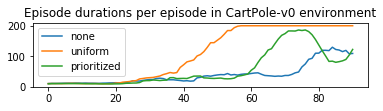

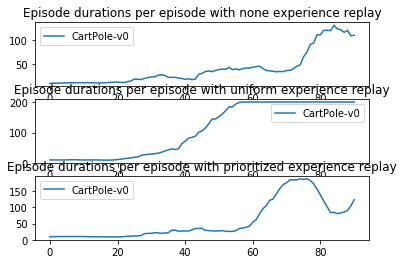

[array([ 10.7,  11.3,  11.2,  11.2,  11.6,  11.9,  12. ,  11.9,  12.3,
        12.2,  11.8,  12.4,  12. ,  12. ,  11.8,  11.4,  12. ,  12.2,
        12.8,  13.1,  13.5,  12.7,  12.6,  14.4,  15.7,  19.7,  19. ,
        18.9,  21.1,  22.6,  23.9,  24. ,  27.5,  28.2,  27. ,  23.1,
        23.1,  23.1,  21.8,  20.7,  19.2,  20. ,  18.6,  19.4,  29.4,
        31.1,  35.1,  36.2,  34.8,  37.2,  38.9,  40.1,  39.6,  43.5,
        38.8,  40.3,  38.4,  40.9,  42.1,  42. ,  43.7,  45.2,  45.9,
        41.2,  37.2,  36.4,  35.6,  34.4,  35.3,  34.7,  37.2,  37.2,
        40.6,  45.8,  48.5,  65.1,  74.9,  90.1,  93.4, 110. , 110.3,
       119.5, 119.6, 118.6, 129.7, 122.3, 120.5, 115.3, 119.3, 108. ,
       109.3], dtype=float32), array([ 10.6,  10.8,  10.7,  10.7,  10.5,  10.9,  11.2,  11.4,  11.2,
        10.9,  10.4,  10.6,  10.7,  10.7,  10.8,  10.4,  10. ,  10. ,
        10.3,  10.7,  12.3,  12.6,  15.2,  16.1,  17.4,  19.3,  20.4,
        25.9,  27.4,  29.2,  30. ,  30.8,  33.1,  35.5,  4

In [476]:

def grid_graphs(): 
    
    #Compare per environment
    for env in environments:
        plt.subplot(3,1, environments.index(env)+1)
        for i in range(len(exp_replays)):
            plt.plot(results[env][i])
        plt.title('Episode durations per episode in {} environment'.format(env))
        plt.legend(exp_replays)
    plt.show()
    
    #Compare per ER
    for i in range(len(exp_replays)):
        plt.subplot(3,1, i+1)
        for env in environments:
            plt.plot(results[env][i])
        plt.title('Episode durations per episode with {} experience replay'.format(exp_replays[i]))
        plt.legend(environments)
    plt.show()
    
grid_graphs()
print(results["CartPole-v0"])

